In [1]:
# importing packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pysal
import splot

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the airbnb data
listings = pd.read_csv('C:/Users/sylwi/OneDrive/Documents/GitHub/NYC_Airbnbs/listings/listings.csv') 
print(listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [3]:
# Subset only a handful of data variables for analysis 
listings_sub = listings[['id', 'property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'price', 'latitude', 'longitude']]

listings_sub.head()

id                property_type neighbourhood_cleansed  \
0  977395984065981849         Private room in home         Sheepshead Bay   
1  648033676238017128  Private room in rental unit            Kingsbridge   
2  871990853610302281  Private room in rental unit           Howard Beach   
3            15943497         Private room in home     Bedford-Stuyvesant   
4  845596919658541172  Private room in rental unit               Flatbush   

  neighbourhood_group_cleansed  accommodates  bedrooms  beds  bathrooms  \
0                     Brooklyn             1       1.0   1.0        1.0   
1                        Bronx             2       1.0   1.0        1.0   
2                       Queens             1       1.0   0.0        0.5   
3                     Brooklyn             1       1.0   1.0        1.0   
4                     Brooklyn             1       4.0   1.0        2.0   

    price   latitude  longitude  
0  $30.00  40.591790 -73.942850  
1  $30.00  40.863940 -73.903120  
2  $85.00  40.663586 -73.834532  
3  $50.00  40.689970 -73.954700  
4  $48.00  40.652979 -73.957686

In [4]:
# Get additional info on listings dataset
listings_sub.info()
pd.options.mode.copy_on_write = True 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            39202 non-null  int64  
 1   property_type                 39202 non-null  object 
 2   neighbourhood_cleansed        39202 non-null  object 
 3   neighbourhood_group_cleansed  39202 non-null  object 
 4   accommodates                  39202 non-null  int64  
 5   bedrooms                      33011 non-null  float64
 6   beds                          24222 non-null  float64
 7   bathrooms                     24335 non-null  float64
 8   price                         24267 non-null  object 
 9   latitude                      39202 non-null  float64
 10  longitude                     39202 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 3.3+ MB


### Conducting Exploratory Data Analysis 

In [5]:
# Clean the data to start
# using .loc to avoid SettingWithCopyWarning above
#listings_sub2 = listings_sub.loc[:, ['price']]

# Given there is no obvious way to impute the data, we can drop beds and bathrooms data which is incomplete
listings_sub.drop(columns = ["beds", "bathrooms"], inplace = True)


# Assuming NA for bedrooms indicates that there are 0 bedrooms, fill in 0
listings_sub["bedrooms"] = listings_sub["bedrooms"].fillna(value=0)


In [6]:
# Calculate the number of missing values
listings_sub.isnull().sum()

id                                  0
property_type                       0
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
accommodates                        0
bedrooms                            0
price                           14935
latitude                            0
longitude                           0
dtype: int64

In [7]:
# Convert price from object to float
listings_cleaned = listings_sub.dropna(subset=['price'])
print(listings_cleaned)

                       id                property_type neighbourhood_cleansed  \
0      977395984065981849         Private room in home         Sheepshead Bay   
1      648033676238017128  Private room in rental unit            Kingsbridge   
2      871990853610302281  Private room in rental unit           Howard Beach   
3                15943497         Private room in home     Bedford-Stuyvesant   
4      845596919658541172  Private room in rental unit               Flatbush   
...                   ...                          ...                    ...   
39193  827584086612689502           Entire rental unit     Bedford-Stuyvesant   
39194            34646398        Private room in condo     Bedford-Stuyvesant   
39198  932893071035345056        Private room in condo               Bushwick   
39200             4352537                 Entire condo               Gramercy   
39201            51861574           Entire rental unit        Upper East Side   

      neighbourhood_group_c

In [8]:
# Calculate the number of missing values again
listings_cleaned.isnull().sum()

id                              0
property_type                   0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
accommodates                    0
bedrooms                        0
price                           0
latitude                        0
longitude                       0
dtype: int64

In [9]:
# Convert price variable from object to float so that we can perform computations of the column
listings_cleaned['price'] = listings_cleaned['price'].replace('[$,]', "", regex=True).astype(float)

In [10]:
# Gather information about the data, particularly the distribution of the price variable
listings_cleaned.describe()

id  accommodates      bedrooms          price      latitude  \
count  2.426700e+04  24267.000000  24267.000000   24267.000000  24267.000000   
mean   4.492633e+17      2.983888      1.372687     206.502946     40.728540   
std    4.355667e+17      2.140425      0.967991    1004.705385      0.058749   
min    2.595000e+03      1.000000      0.000000      10.000000     40.500314   
25%    3.732767e+07      2.000000      1.000000      80.000000     40.686546   
50%    5.973046e+17      2.000000      1.000000     129.000000     40.728110   
75%    8.637016e+17      4.000000      2.000000     212.000000     40.763440   
max    1.084860e+18     16.000000     16.000000  100000.000000     40.911147   

          longitude  
count  24267.000000  
mean     -73.942532  
std        0.059672  
min      -74.251907  
25%      -73.982560  
50%      -73.952450  
75%      -73.920640  
max      -73.713650

The nightly price for Airbnbs in New York City is \\$206.5 with the maximum being \\$100,000, indicating a large skew in the data. To visually represent the skewness, plot a histogram with a kernel density estimation

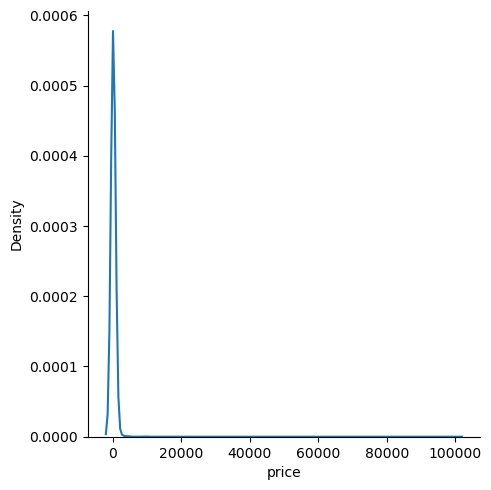

In [11]:
# Visual representation of distribution of data, data is clearly unimodal with a clear peak
sns.displot(listings_cleaned['price'], kind='kde', bw_adjust=5)
plt.show()

In [12]:
# Find index values for max outliers
listings_cleaned.index[listings_cleaned['price']==100000.0].tolist()

# Drop observation that is 100,000/night as it is an outlier and incorrectly listed
listings_cleaned.drop(index=[12916, 16444], inplace=True)

## Exploratory Spatial Data Analysis (ESDA)
To begin ESDA, convert the pandas DtaFrame into a GeoPandas DataFrame and set the coordinate reference system (CRS) to a well-known iD (WKID) of 4326. Then plot the observations as a point map and a heatmap, which will display density of points in an area as a raster.

In [13]:
# Convert pandas dataframe to a geopandas dataframe
listings_gpd = gpd.GeoDataFrame(listings_cleaned, geometry=gpd.points_from_xy(listings_cleaned.longitude, listings_cleaned.latitude, crs=4326))
listings_gpd.head()

id                property_type neighbourhood_cleansed  \
0  977395984065981849         Private room in home         Sheepshead Bay   
1  648033676238017128  Private room in rental unit            Kingsbridge   
2  871990853610302281  Private room in rental unit           Howard Beach   
3            15943497         Private room in home     Bedford-Stuyvesant   
4  845596919658541172  Private room in rental unit               Flatbush   

  neighbourhood_group_cleansed  accommodates  bedrooms  price   latitude  \
0                     Brooklyn             1       1.0   30.0  40.591790   
1                        Bronx             2       1.0   30.0  40.863940   
2                       Queens             1       1.0   85.0  40.663586   
3                     Brooklyn             1       1.0   50.0  40.689970   
4                     Brooklyn             1       4.0   48.0  40.652979   

   longitude                    geometry  
0 -73.942850  POINT (-73.94285 40.59179)  
1 -73.903120  POINT (-73.90312 40.86394)  
2 -73.834532  POINT (-73.83453 40.66359)  
3 -73.954700  POINT (-73.95470 40.68997)  
4 -73.957686  POINT (-73.95769 40.65298)

<GeoAxes: >

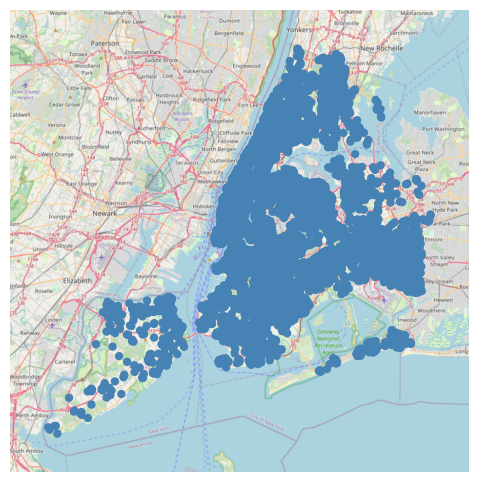

In [14]:
import geoplot.crs as gcrs
import geoplot as gplt

# Plot a point map using the long and lat observations, initializing a web map and setting the projection to Web Mercator
ax = gplt.webmap(listings_gpd, projection=gcrs.WebMercator())
gplt.pointplot(listings_gpd, ax=ax)

## Create a Heatmap
A heatmap is a spatial visualization that allows you to see the density of points in an area as a raster and will provide us with better information than the above point map. Start by reading in a shapefile associated with NYC's five boroughs. Then use geoplot's kdeplot and polyplot to create a heatmap on top of the boroughs data.

<Axes: >

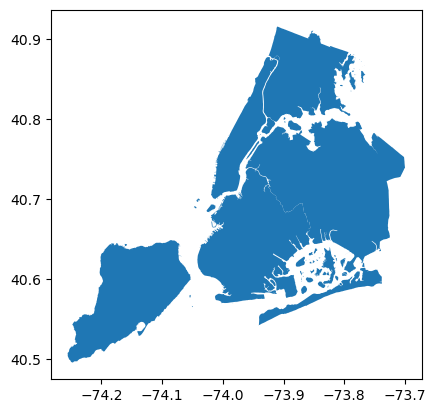

In [15]:
# Create borough boundaries with data from NYC Open Data
Boroughs = gpd.read_file("C:/Users/sylwi/OneDrive/Documents/GitHub/NYC_Airbnbs/NYC Boroughs/nybb_23d/nybb.shp")
Boroughs = Boroughs.to_crs(4326)
Boroughs.plot()

In [16]:
Boroughs.info

<bound method DataFrame.info of    BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  325917.353950  1.623621e+09   
1         1      Manhattan  357713.308162  6.365205e+08   
2         2          Bronx  463180.579449  1.187175e+09   
3         3       Brooklyn  728146.574928  1.934138e+09   
4         4         Queens  888199.731385  3.041419e+09   

                                            geometry  
0  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
1  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
2  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
3  MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...  
4  MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...  >

<GeoAxes: >

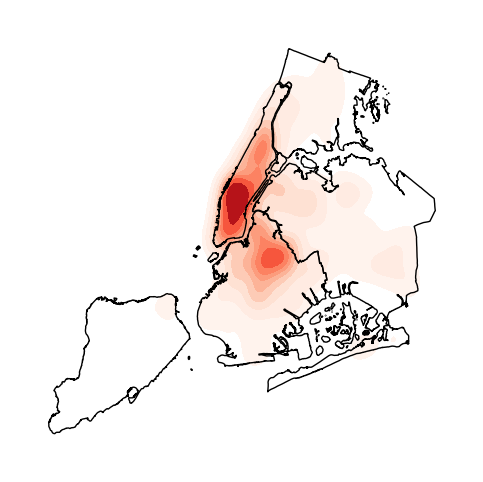

In [17]:
# Create a heatmap of Airbnb locations using kdeplot and polyplot
ax = gplt.kdeplot(listings_gpd, fill=True, cmap='Reds', projection=gcrs.WebMercator())

# Plot the heatmap on top of the boroughs for context
gplt.polyplot(Boroughs, ax=ax, zorder=1)

## Convert point maps to Census Tract Maps
To make the data easier to work with, aggregate it up to census tract level and take the average price of listings that fall within each census tract. Then, subset the census tracts to those in the New York core-based statistical area (CBSA) which are U.S. geographic areas defined by the Office of Management and Budget (OMB).


In [18]:
# Convert from point maps to census tract maps by aggregating up to the census tract level and taking the average price of the listings that fall within each census tract
# Read in the New York Census Tracts data from Census Bureau website and spatially join and dissolve the listings data
NY_tracts_path = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip"
NY_Tracts = gpd.read_file(NY_tracts_path)
NY_Tracts = NY_Tracts.to_crs(4326)

In [19]:
# Subset the census tracts to those in the New York core-based statistical area (CBSA) which are U.S. geographic areas defined by the Office of Management and Budget (OMB)
cbsa_path = "https://www2.census.gov/geo/tiger/TIGER2021/CBSA/tl_2021_us_cbsa.zip"
cbsas = gpd.read_file(cbsa_path)

# Utilize GEOID 35620 for New York-Newark-Jersey City, NY-NJ CBSA from https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html
NY_cbsas = cbsas[cbsas['GEOID']=='35620']

mask = NY_Tracts.intersects(NY_cbsas.loc[620, 'geometry'])
NY_Tracts_subset = NY_Tracts.loc[mask]

In [20]:
# Aggregate the airbnb locations that fall within the NY census tracts
NY_Tracts_sj = gpd.sjoin(NY_Tracts_subset, listings_gpd, how='inner', predicate='contains')
NY_Tracts_sj = NY_Tracts_sj[['GEOID', 'price', 'geometry', 'accommodates', 'bedrooms']]
NY_Tracts_Agg = NY_Tracts_sj.dissolve(by='GEOID', aggfunc='mean')

<Axes: >

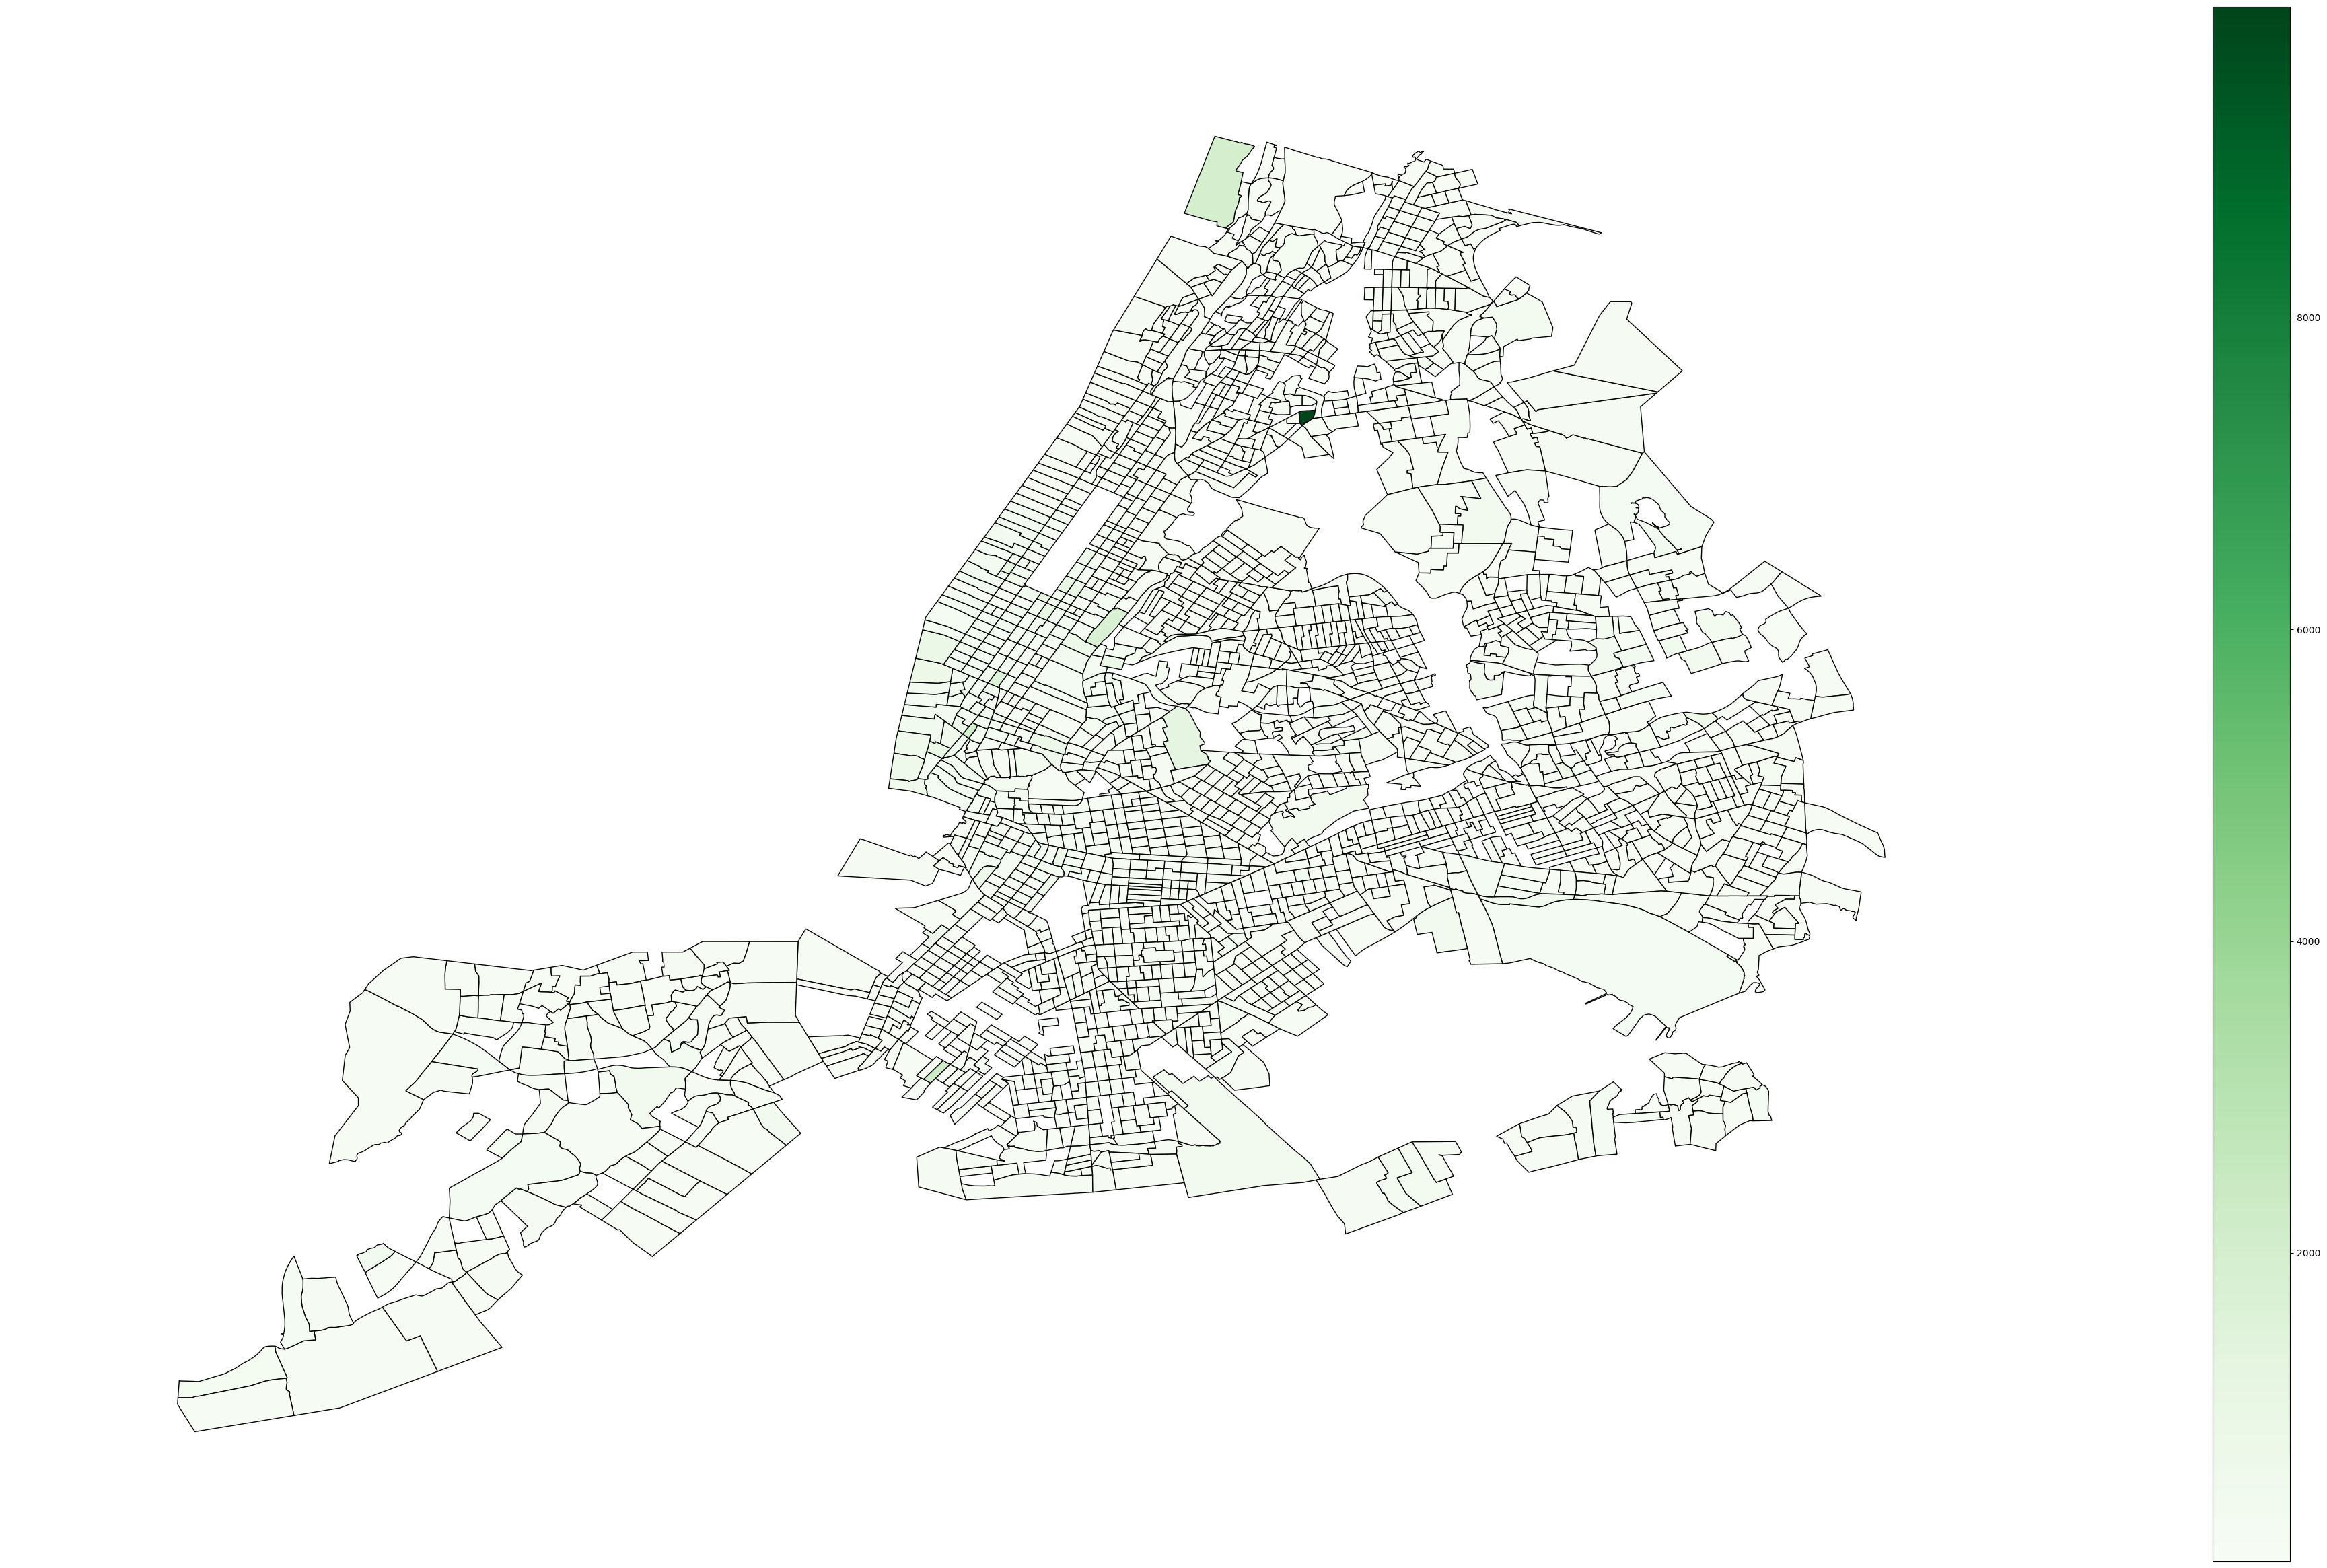

In [21]:
# Plot the data using geoplot to see how price is distributed by census tract
gplt.choropleth(NY_Tracts_Agg, hue='price', cmap='Greens', figsize=(60,30), legend=True)

## Create Interactive Map Using Bokeh's Geoviews package
Given there is a large number of census tracts that do not have any listing information, these are given a light green color making it difficult to identify areas of interest like NYC. It may be better to produce an interactive map that will allow the end user to zoom in on areas of interest.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
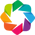

:Polygons   [Longitude,Latitude]   (price,GEOID)

In [22]:
# Use geoviews package with bokeh extension to creative interactive map for zooming in
import geoviews
geoviews.extension("bokeh")

choropleth = geoviews.Polygons(data=NY_Tracts_Agg, vdims=['price', 'GEOID'])

choropleth.opts(height=600, width=900, title="NYC Airbnb Price", tools=["hover"], cmap="Greens", colorbar=True, colorbar_position="bottom")

## Create Chloropleth Without Outliers

In [23]:
# Drop outliers that are more than one standard deviation from the mean NYC airbnb price and replot
import statistics

# Calculate the mean and standard deviation
mean_price = statistics.mean(NY_Tracts_Agg['price'].dropna())
st_dev = statistics.stdev(NY_Tracts_Agg['price'].dropna())

print("The mean Airbnb price is: % s " % (round(mean_price, 2)))
print("The standard deviation of Airbnb prices is: % s " % (round(st_dev, 2)))

The mean Airbnb price is: 163.06 
The standard deviation of Airbnb prices is: 266.41 


In [24]:
# Drop records that are more than 1 standard deviation from the mean
NY_Tracts_Agg_filtered = NY_Tracts_Agg[NY_Tracts_Agg['price'] < mean_price+st_dev]

In [25]:
# Plot a more refined choropleth map
choropleth = geoviews.Polygons(data=NY_Tracts_Agg_filtered, vdims=["price", "GEOID"])

choropleth.opts(height=600, width=900, title="NYC Airbnb Price", tools=["hover"], cmap="Greens", colorbar=True, colorbar_position="bottom")

:Polygons   [Longitude,Latitude]   (price,GEOID)

## Hypothesis Testing and Spatial Randomness
The ESDA allowed us to see some patterns in the data, heavily skewed across New York's geography. Not surprisingly, highest prices seem to be concentrated in Manhattan and pockets of Brooklyn. 

Testing for spatial structure next is important because if it is present in the data, it can be leveraged to enhance downstream analysis. This can be done by using a specialized algorithm during a model-building process that can understand patterns from both data and geographic space. 

Data that has no spatial structure is said to have been generated by an independent random process (IRP). IRP is data that exhibits complete spatial randomness (CSR). IRP/CSR are often interchangeable terms and must satisfy two conditions in order to construct a valid hypothesis test: 
   * A first-order effect must be present, which means that an observation must have an equal probability of occuring in any location (e.g., spread of infectious disease)
   * A second-order effect must be present, which means that observations vary from place to place due to interaction effects between observations (e.g., the location of an observation is independent and does not impact the location of any other observation). 
   
When testing for IRP/CSR, the hypothesis test is as follows: 

H<sub>0</sub> (Null Hypothesis): The data is distributed randomly across space

H<sub>a</sub> (Alternate Hypothesis): The data exhibits a spatial structure and is not randomly distributed

### Calculating Moran's I
Moran's I measures spatial autocorrelation of data based on feature values and feature locations. Spatial autocorrelation measures the variation of a variable by taking an observation and seeing how similar or different it is compared to other observations within its neighborhood. <b>Global</b> spatial autocorrelation measures the trend in an overall dataset the degree of spatial clustering present. <b>Local</b> spatial autocorrelation measures the localized variation in the dataset to detect the presence of hot or cold spots.

To calculate spatial autocorrelation, spatial weights and lags must first be calculated. There are three main spatial weights matrices: the rook continguity matrix, queen continguity matrix, and K-Nearest Neighbors matrix. They are all calculated using Euclidian distance, or straight-line distance. A spatial lag then averages the values of the nearest neighbors. 

In [26]:
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
from IPython.display import display, Markdown, display_latex, display_markdown, display_html
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

In [27]:
# Begin global spatial autocorrelation test
# First generate spatial weights matrix of the listings data using queen-based spatial weights matrix which takes eight nearest neighbors from every observation
# Convert this to polygon data
w = weights.Queen.from_dataframe(NY_Tracts_Agg_filtered)

# Row-standardization which divides the weight for a feature by the sum of all neighbor weights for that same feature. Recommended to be applied any time there is potential bias due to the sampling construct or the aggregation process 
w.transform = 'R'

('WARNING: ', 435, ' is an island (no neighbors)')
('WARNING: ', 611, ' is an island (no neighbors)')
('WARNING: ', 1886, ' is an island (no neighbors)')


In [28]:
# Calculate spatial lag which is the byproduct of the spatial weights matrix that averages prices of the airbnbs in the neighborhood, as defined by the spatial weights matrix chosen
NY_Tracts_Agg_filtered['price_lag'] = weights.spatial_lag.lag_spatial(w, NY_Tracts_Agg_filtered['price'])

In [29]:
# Standardize the variable of interest and the lag variable, which helps to see values above or below the mean easier when plotting Moran's I scatter plot
NY_Tracts_Agg_filtered['price_std'] = (NY_Tracts_Agg_filtered['price'] - NY_Tracts_Agg_filtered['price'].mean())
NY_Tracts_Agg_filtered['price_lag_std'] = (NY_Tracts_Agg_filtered['price_lag'] - NY_Tracts_Agg_filtered['price_lag'].mean())

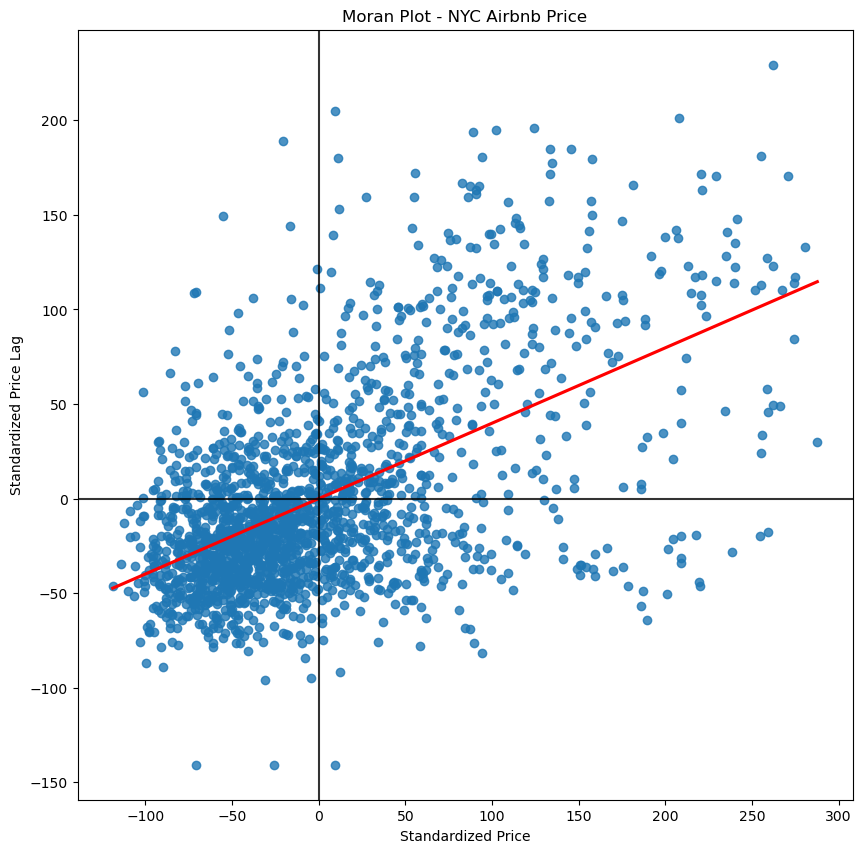

In [30]:
# Moran's I scatter plot
# Plot the spatial weights and spatial lag against each other
f, ax = plt.subplots(1, figsize=(10,10))
sns.regplot(
    x='price_std', # variable of interest
    y='price_lag_std', # spatial lag
    ci=None, # suppress the plotting of the confidence interval
    data=NY_Tracts_Agg_filtered, # dataset
    line_kws={'color':'r'}
)

ax.axvline(0, c='k', alpha=0.8)
ax.axhline(0, c='k', alpha=0.8)

ax.set_title('Moran Plot - NYC Airbnb Price')
ax.set_xlabel('Standardized Price')
ax.set_ylabel('Standardized Price Lag')
plt.show()

Points in the upper-right quadrant have a positive global spatial autocorrelation which means observations within those neighborhoods have similar values. Meanwhile points in the lower-left quadrant have a negative spatial autocorrelation which means low values are next to high values. A line of best fit shows the strength of the relationship which appears to be strong as points are distributed above/below the line of best fit to roughly the same degree.


**Morans I:** 0.39811286944535856

**p-value:** 0.001

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.4', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.4)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

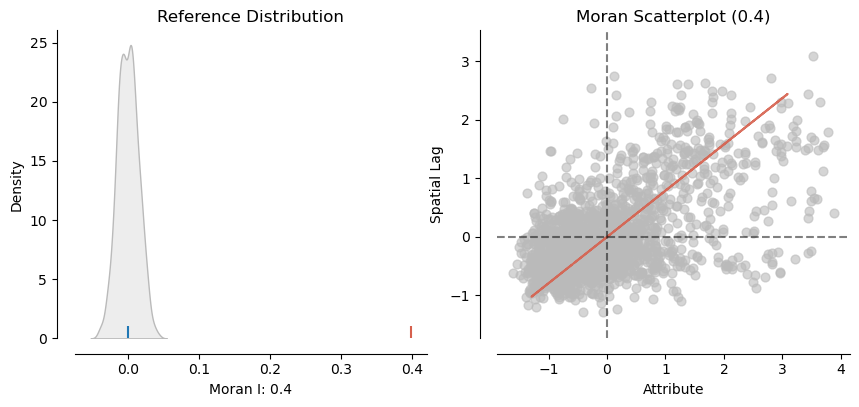

In [31]:
# Calculate the Moran's I statistic by using the Moran module
morans_stat = esda.moran.Moran(NY_Tracts_Agg_filtered['price'], w)
display(Markdown(f"""**Morans I:** {morans_stat.I}"""))
display(Markdown(f"""**p-value:** {morans_stat.p_sim}"""))

plot_moran(morans_stat)

Moran's I statistics is ~0.4, with a p-value of 0.001. This indicates statistically significant spatial relationship present in the NYC Airbnb price data. This leads to a rejection of the null hypothesis and instead concluding that the listings data is spatially clustered together in such a way that it is unlikely to have occurred by chance alone.


**Morans I for accommodates:** 0.1502245682122509

**p-value for accommodates:** 0.001

**Morans I for bedrooms:** 0.15789855493199553

**p-value for bedrooms:** 0.001

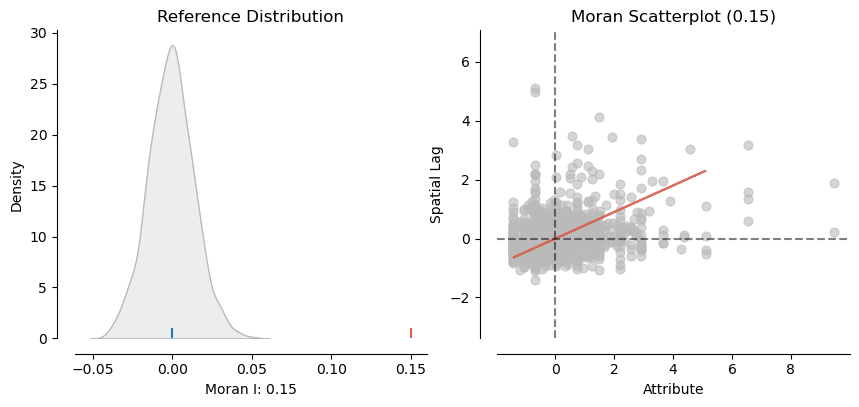

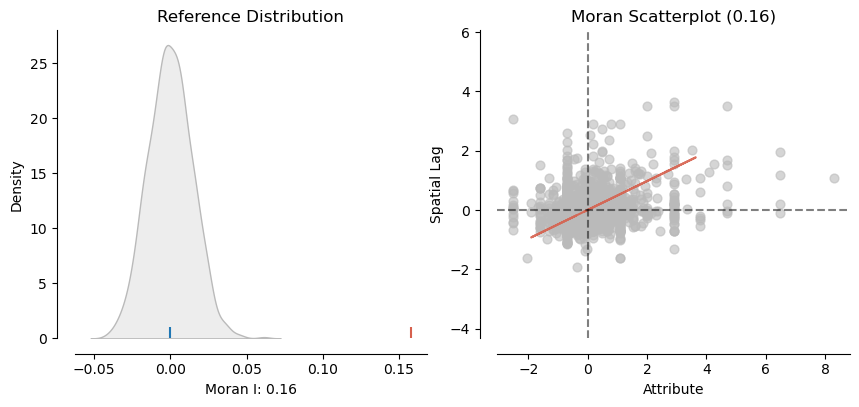

In [32]:
# Explore additional variables of interest for significance in the dataset
import numpy as np
from esda.moran import Moran

# Set seed for NumPy for reproducibility
np.random.seed(54321)

# Set the variables of interest
variables_of_interest = ['accommodates','bedrooms']

for voi in variables_of_interest:
    morans_stat = esda.moran.Moran(NY_Tracts_Agg_filtered[voi], w)
    display(Markdown(f"""**Morans I for {voi}:** {morans_stat.I}"""))
    display(Markdown(f"""**p-value for {voi}:** {morans_stat.p_sim}"""))
    plot_moran(morans_stat)

In [33]:
# Geary's C statistic, which uses squared differences that are less sensitive to linear associations
# Set the variables of interest
variables_of_interest = ['price','accommodates','bedrooms']

for voi in variables_of_interest:
    geary_c = esda.geary.Geary(NY_Tracts_Agg_filtered[voi], w)
    display(Markdown(f"""**Geary's C for {voi}:** {geary_c.C}"""))
    display(Markdown(f"""**p-value for {voi}:** {geary_c.p_sim}"""))

**Geary's C for price:** 0.5942687047406697

**p-value for price:** 0.001

**Geary's C for accommodates:** 0.877453440341057

**p-value for accommodates:** 0.001

**Geary's C for bedrooms:** 0.8336077173253658

**p-value for bedrooms:** 0.001

### Local spatial autocorrelation
Local spatial autocorrelation measures the relationship between each observation and its localized surroundings. First, calculate Local Indicators of Spatial Associations (LISAs). LISAs are spatial statistics that are derived from global spatial statistics and calculate local cluster patterns, known as spatial outliers. Spatial outliers are unlikely to appear if assumption of spatial randomness is true.

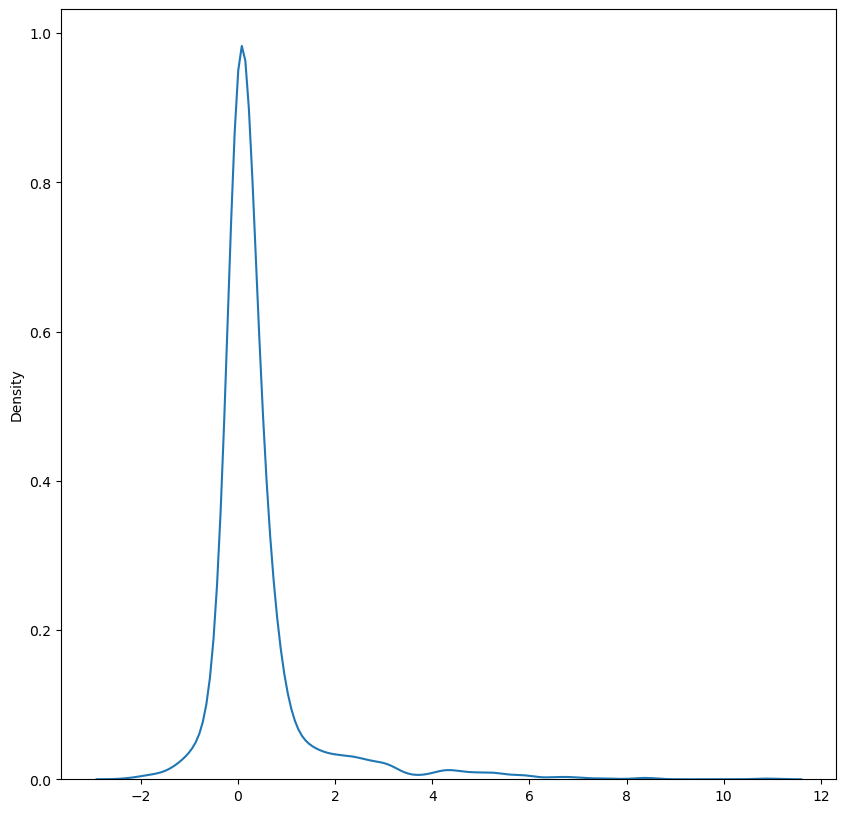

In [34]:
# Local spatial autocorrelation using Local Indicators of Spatial Associations (LISAs)
price_lisa = esda.moran.Moran_Local(NY_Tracts_Agg_filtered['price'], w)

# Drawing KDE line
f, ax = plt.subplots(1, figsize=(10, 10))
sns.kdeplot(price_lisa.Is, ax=ax)

plt.show()

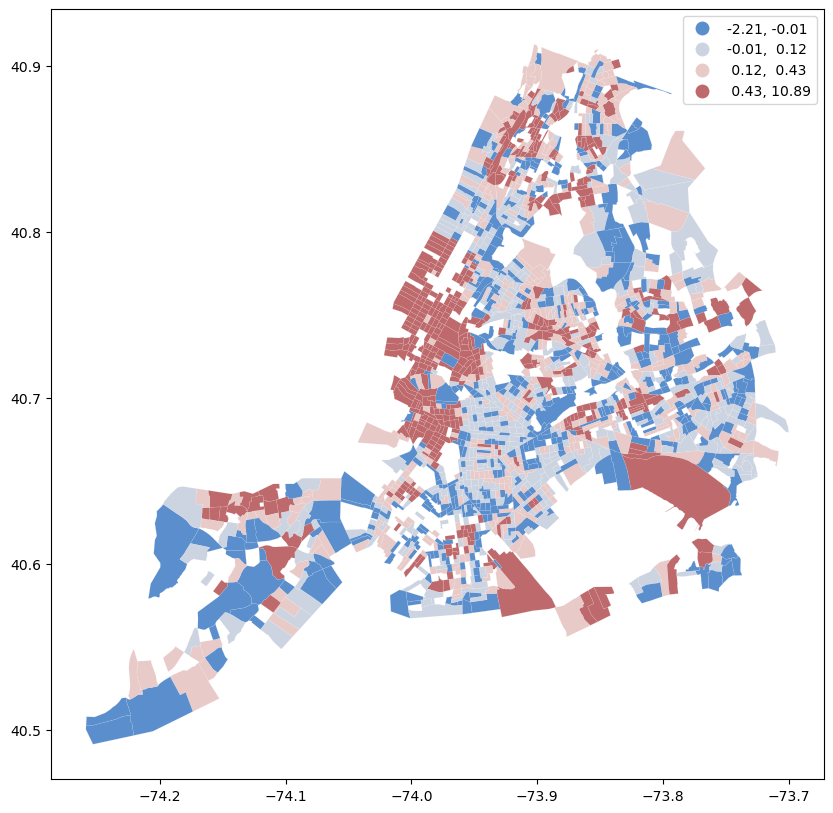

In [35]:
# Data above shows massive spike in data around 0 with a long right tail. This is mainly due to presence of a large number of observations with positive spatial autocorrelation, which is in line with the global measures from before
f, ax = plt.subplots(1, figsize=(10, 10))

# Create a new column with the values from the Moran's Local LISAs
NY_Tracts_Agg_filtered.assign(
    ML_Is=price_lisa.Is
    
# Plot choropleth of local statistics
).plot(
    column='ML_Is', 
    cmap='vlag', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

plt.show()

Next, assign each observation to its quadrant: High-High, High-Low, Low-High, and Low-Low. Then, assess for statistical significance. 

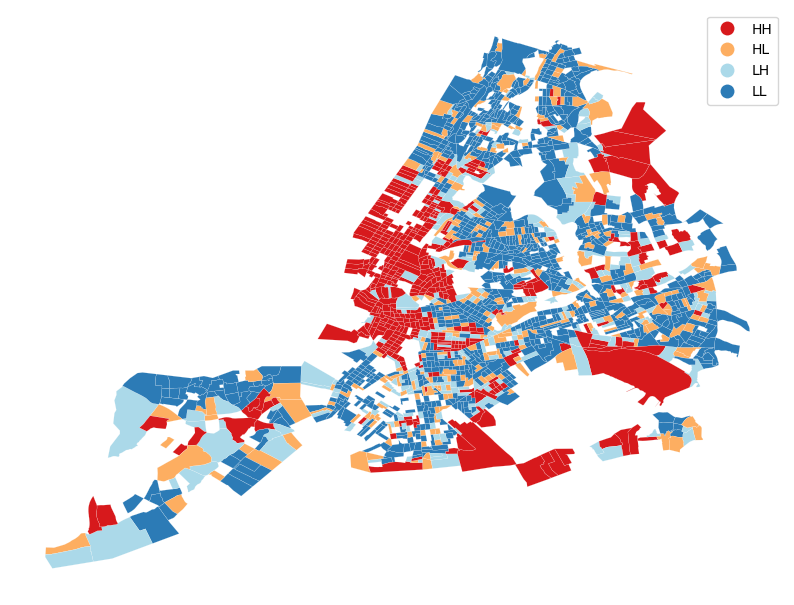

In [36]:
# import additional package esda from splot
from splot import esda as esdaplot

# Plot a map assigning each observation with its quadrant value HH, HL, LH, LL
f, ax = plt.subplots(1, figsize=(10, 10))
esdaplot.lisa_cluster(price_lisa, NY_Tracts_Agg_filtered, p=1, ax=ax);

plt.show()

In [ ]:
# Find points that are statistically significant at alpha of 0.05
f, ax = plt.subplots(1, figsize=(10, 10))

# First, find which observations are significant
alpha = 0.05
labels = pd.Series(
    1 * (price_lisa.p_sim < alpha), # 1: Indicates significance at alpha of .05 and 0 indicates insignificant values
    index=NY_Tracts_Agg_filtered.index

# Recode 1 to be "Significant and 0 to be "Insignificant"
).map({1: 'Significant', 0: 'Insignificant'})

# Creating a new column with the labels for significance called ML_Sig
NY_Tracts_Agg_filtered.assign(
    ML_Sig=labels

# Plot a map of the insignificant values
).plot(
    column='ML_Sig', 
    categorical=True,
    k=2,
    cmap='vlag',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

In [ ]:
# Plot one final map using the alpha of 0.05 showing quadrant values for the significant observations and a fifth value representing insignificant observations
f, ax = plt.subplots(1, figsize=(10, 10))

esdaplot.lisa_cluster(price_lisa, NY_Tracts_Agg_filtered, p=alpha, ax=ax);

plt.show()

### Point Pattern Analysis
Point pattern analysis centers around the patterns present within point data instead of the attributes associated with the point data, often measured in terms of dispersion and clustering. Most of the statistics to measures pattern o rlack thereof in point data are within Ripley's alphabet functions. 

In [ ]:
# Utilize a dataset of Dollar General retail store locations within Ohio, sourcing the data from OpenStreetMap API under the Open Data License.
# Import packages
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn
import contextily
import matplotlib.pyplot as plt
import osmnx as ox
from pointpats import distance_statistics, QStatistic, random, PointPattern

In [ ]:
# Utilize exercise from https://github.com/PacktPublishing/Applied-Geospatial-Data-Science-with-Python/blob/main/OSM%20POI%20Data%20Pulls_vf.ipynb to download data
search_area = "OH, USA"
area = ox.geocode_to_gdf(search_area)
area.plot

In [ ]:
tags = {'brand':'Dollar General'} 
buildings = ox.features_from_place(search_area, tags)
buildings.head()

In [ ]:
DG_points = buildings[buildings.geom_type == 'Point']
DG_points['X'] = DG_points.geometry.x
DG_points['Y'] = DG_points.geometry.y
DG_points.head(10)

In [ ]:
# Set file path
data_path = r'C:/Users/sylwi/OneDrive/Documents/GitHub/NYC_Airbnbs/'

# Write points to csv
locs_dg = DG_points.to_csv(data_path + 'OSM_DollarGeneralLocs.csv')

locs_pdf = pd.read_csv(data_path + 'OSM_DollarGeneralLocs.csv')

In [ ]:
# Convert the pandas dataframe into a geopandas geodataframe
locs_gdf = gpd.GeoDataFrame(locs_pdf, geometry=gpd.points_from_xy(locs_pdf.X, locs_pdf.Y), crs="EPSG:4326")

In [ ]:
g_test = distance_statistics.g_test(locs_gdf[['X', 'Y']].values, support=40, keep_simulations=True)

In [ ]:
plt.plot(g_test.support, np.median(g_test.simulations, axis=0),
        color='k',
        label='Simulated Data')
plt.plot(g_test.support, g_test.statistic, marker='x', color='orangered', label='Observed Data')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Ripleys G Function')
plt.title('Ripleys G Function Plot')
plt.show()

The orange line represents the cumulative distance function from the store locations dataset while the black line represents a simulated CSR distribution. Between 0 and ~.25, the data rises much more rapidly than the simulated data from CSR. We can deduce that the store location data has a significant spatial pattern.

Next, test the store locations with the Ripley's K function which considers all distances and not just those of the cloest neighbor. 

In [ ]:
# Call k_test() function from pointpats to run Ripley's K
k_test = distance_statistics.k_test(locs_gdf[['X', 'Y']].values, keep_simulations=True)

In [ ]:
# Plot output
plt.plot(k_test.support, k_test.simulations.T, color='k', alpha=0.1)
plt.plot(k_test.support, k_test.statistic, color='orange')

plt.scatter(k_test.support, k_test.statistic, cmap='viridis', c=k_test.pvalue < 0.5, zorder=4)
plt.xlabel('Distance')
plt.ylabel('Ripleys K Function')
plt.title('Ripleys K Function Plot')
plt.show()

The observed data is above that of the simulated data, which confirms that the data is from a process that is not spatially random. It makes sense that the store locations exhibit a pattern as locations are likely decided upon given a set of geodemographic characteristics that result in positive business performance. 